In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import shapiro

from eff.analysis import mann_whitney_test, wilcoxon_signed_rank_test, get_significance_level
from eff.analysis.plotting import set_lang_ax
from eff.util.util import load_results

np.random.seed(0)
base_path = Path("./out/nelex_unique")

fontsize=24

In [2]:
non_vh_langs =  ['arb', 'ain', 'ekk', 'hye', 'eus']

id2name = dict(
    fin="Finnish", arb="Arabic", 
    tur="Turkish", ain="Ainu", 
    mnc="Manchu", ekk="Estonian", 
    hun="Hungarian", hye="Armenian", 
    khk="Khalkha Mongolian", eus="Basque"
)

****************************************
*** ARB
****************************************
*** HARMONY/DISHARMONY
& front\_harmonic/disharmonic & -0.5412 &  2958.0 & 5.988457440576305e-56 & 0.039 \\
& round\_harmonic/disharmonic & 0.5471 & 2611.0 & 9.195202243541577e-58 & 0.0337 \\
& front/round\_disharmonic & 0.5445 & 145867.5 & 4.236468057649243e-107 & 0.9083 \\
0 3.75
*** +-BACK HARMONY
& front\_front/front\_back & -0.6584 &  65.0 & 4.384063846007799e-56 & 0.0012 \\
& back\_back/back\_front & 0.1558 & 300.0 & 4.859952116064424e-05 & 0.188 \\
& front\_back/back\_front & 0.3974 & 17750.0 & 2.685140357009599e-27 & 0.9037 \\
*** +-ROUND HARMONY
& round\_round/round\_unround & -0.2253 &  29.0 & 1.7727336433612673e-05 & 0.0585 \\
& unround\_unround/unround\_round & 0.6132 & 463.0 & 2.0174339002238195e-59 & 0.007 \\
& round\_unround/unround\_round & 0.4301 & 10796.0 & 1.3292092237995894e-17 & 0.9241 \\
****************************************
*** AIN
****************************************

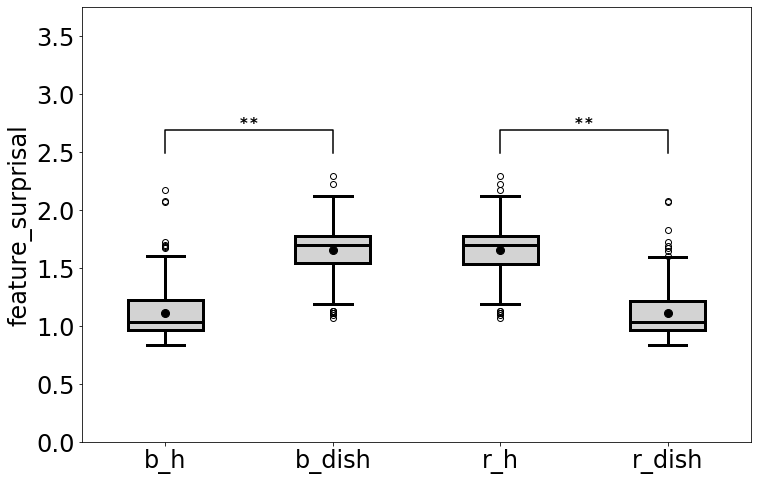

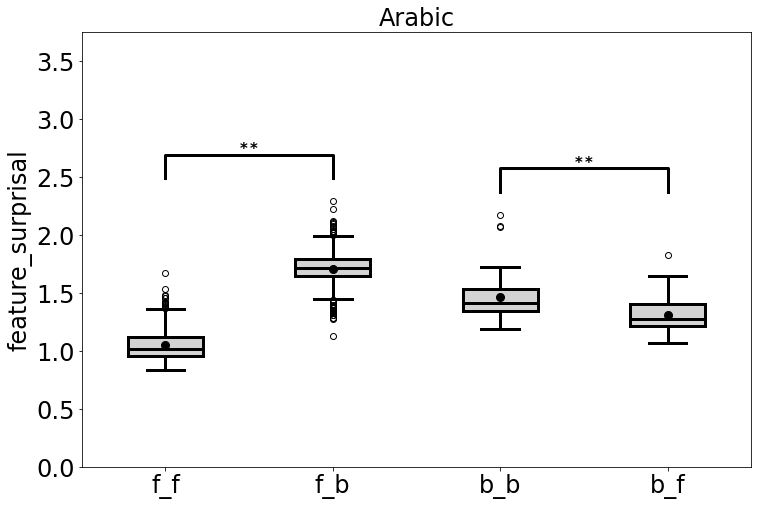

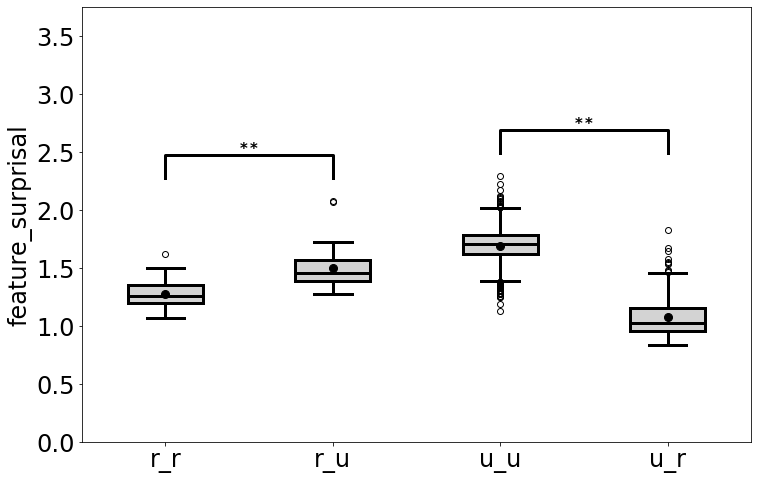

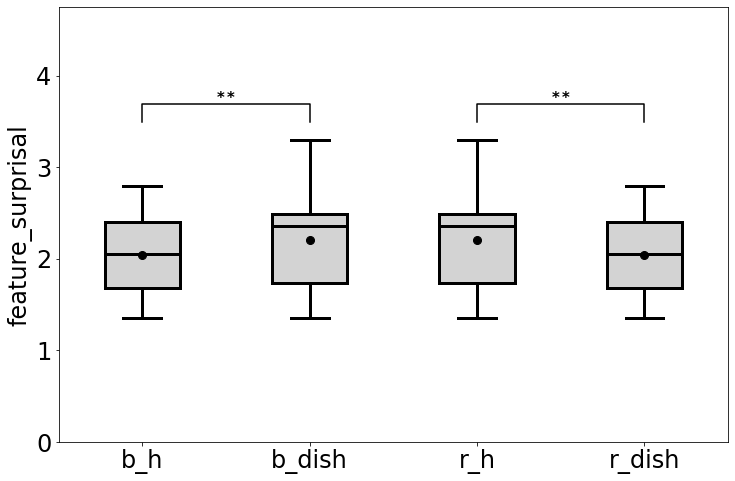

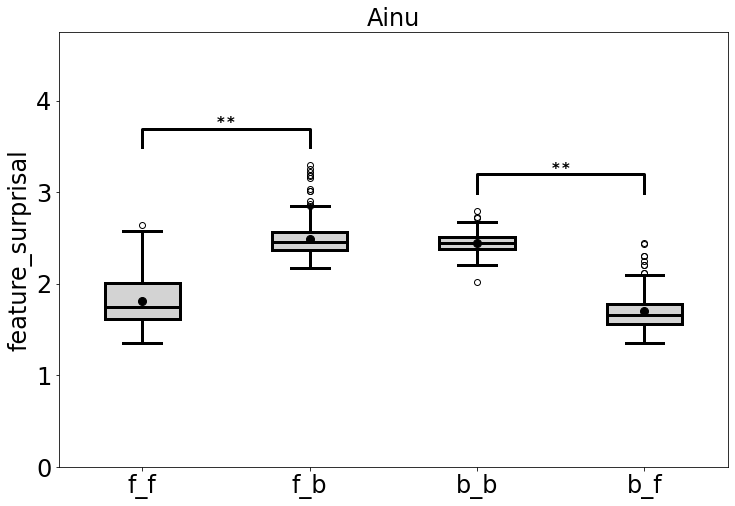

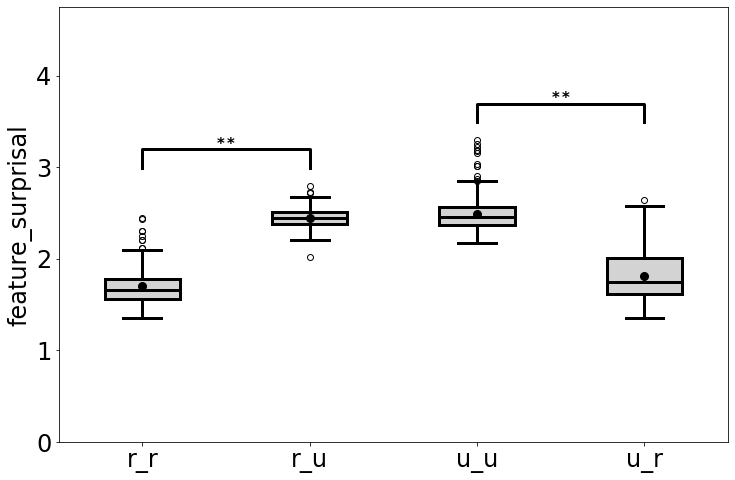

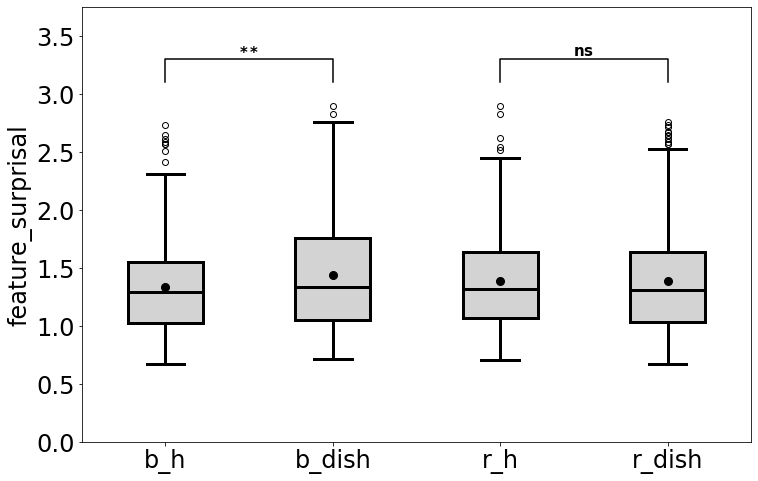

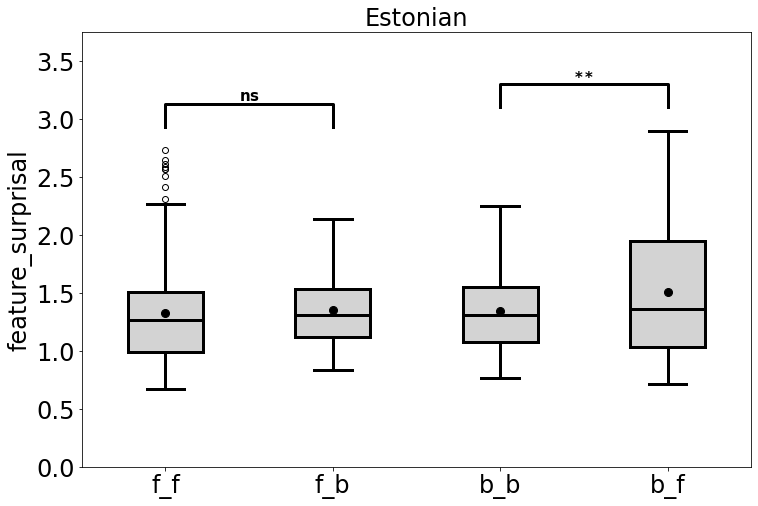

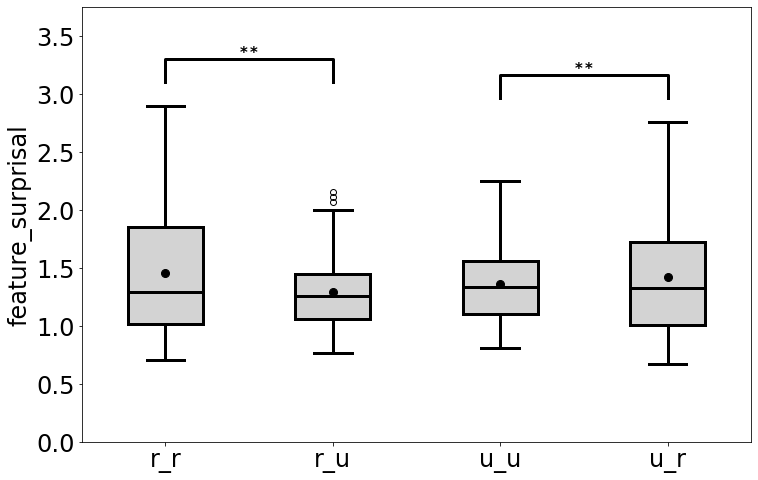

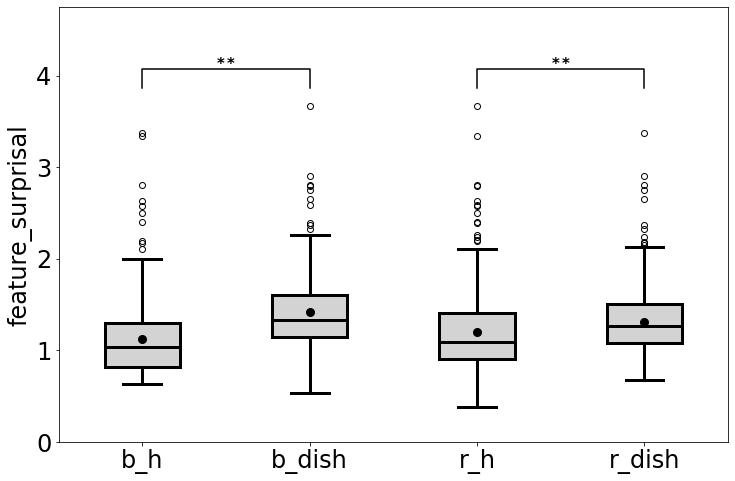

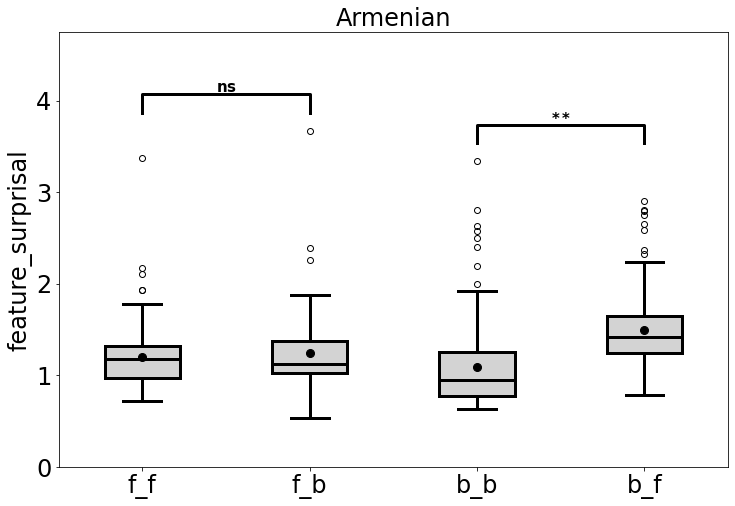

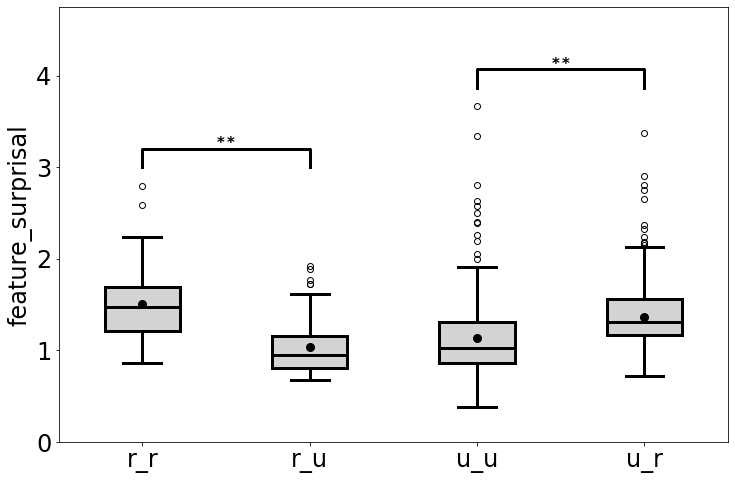

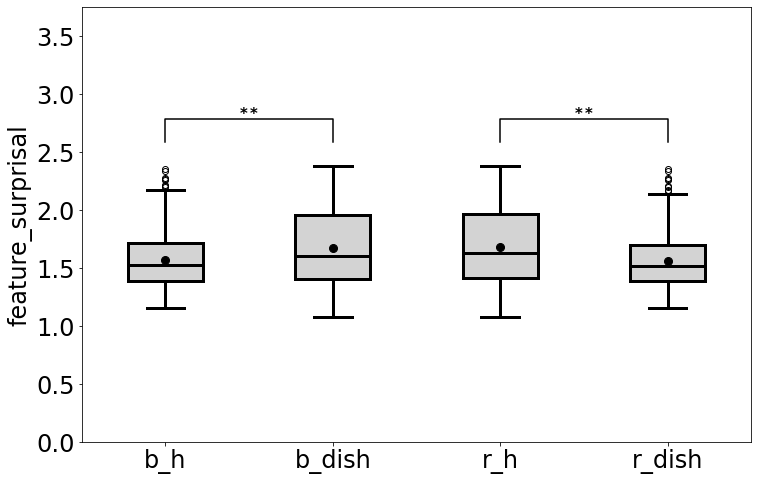

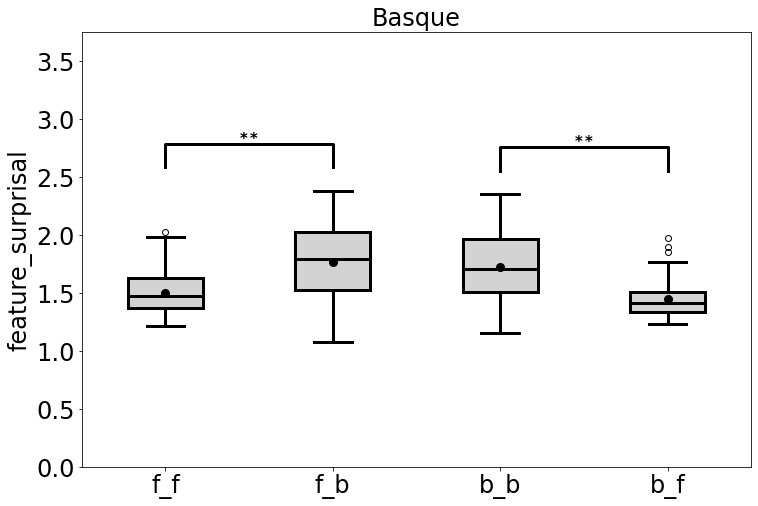

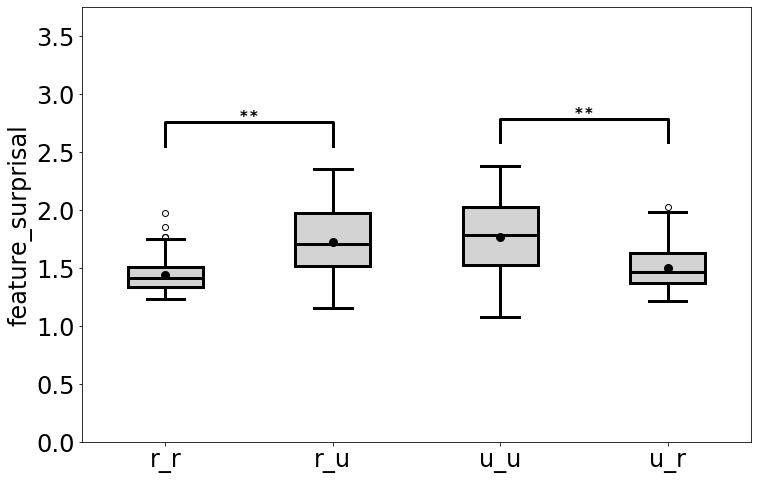

In [3]:
for lang_id in non_vh_langs:
    print(40*"*")
    print("***", lang_id.upper())
    print(40*"*")
    # load results
    dataset, res, criterion, model = load_results(base_path, lang_id)
    clts_ds = dataset['clts']
    bipa = clts_ds.bipa
    output_alphabet = clts_ds.output_alphabet
    logprobs = res['unmasked']['logprobs']
    targets = res['unmasked']['targets']
    target_indices = res['unmasked']['indices']

    # model probe front harmony 
    front_vowels = [v for v in output_alphabet.symbols if bipa[v].type == 'vowel' and 'front' in bipa[v].featureset] 
    back_vowels = [v for v in output_alphabet.symbols if bipa[v].type == 'vowel' and 'back' in bipa[v].featureset] 

    front_indices = [output_alphabet.char2idx(v) for v in front_vowels]
    back_indices = [output_alphabet.char2idx(v) for v in back_vowels]
    ff_surprisal = []
    bb_surprisal = []
    fb_surprisal = []
    bf_surprisal = []
    for indices_word, targets_word, logprobs_word in zip(target_indices, targets, logprobs):
        vowel_indices = [targets_word[idx] for idx in indices_word]
        if len(vowel_indices) >= 2:
            for i in range(len(vowel_indices)-1, 0, -1):
                idx = vowel_indices[i]
                prev_idx = vowel_indices[i-1]
                target_idx = indices_word[i] # first index of the logprobs
                # need char to determine harmonic group
                vowel = output_alphabet.idx2char(idx)
                prev_vowel = output_alphabet.idx2char(prev_idx)

                fset1 = clts_ds.bipa[vowel].featureset
                fset2 = clts_ds.bipa[prev_vowel].featureset

                if not clts_ds.bipa[vowel].type == 'diphthong' \
                and not clts_ds.bipa[vowel].type == 'diphthong':

                    if prev_vowel in front_vowels:
                        target_logprobs = logprobs_word[target_idx]
                        harmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in front_indices])
                        disharmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in back_indices])
                        harmonic_surprisal = -np.log2(harmonic_surprisal)
                        disharmonic_surprisal = -np.log2(disharmonic_surprisal)
                        ff_surprisal.append(harmonic_surprisal)
                        fb_surprisal.append(disharmonic_surprisal)
                    elif prev_vowel in back_vowels:
                        target_logprobs = logprobs_word[target_idx]
                        harmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in back_indices])
                        disharmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in front_indices])
                        harmonic_surprisal = -np.log2(harmonic_surprisal)
                        disharmonic_surprisal = -np.log2(disharmonic_surprisal)
                        bb_surprisal.append(harmonic_surprisal)
                        bf_surprisal.append(disharmonic_surprisal)

    n_ff = len(ff_surprisal)
    n_fb = len(fb_surprisal)
    n_bb = len(bb_surprisal)
    n_bf = len(bf_surprisal)

    front_harmonic_surprisal = ff_surprisal + bb_surprisal
    front_disharmonic_surprisal = fb_surprisal + bf_surprisal

    delta_mean_f = np.mean(ff_surprisal) - np.mean(fb_surprisal)
    delta_mean_b = np.mean(bb_surprisal) - np.mean(bf_surprisal)
    delta_mean_disharmonic_front = np.mean(fb_surprisal) - np.mean(bf_surprisal)
    # print(delta_mean_f)
    # print(delta_mean_b)
    # print(delta_mean_disharmonic_front)

    # print(shapiro(front_harmonic_surprisal))
    # print(shapiro(front_disharmonic_surprisal))

    # print(shapiro(ff_surprisal))
    # print(shapiro(fb_surprisal))
    # print(shapiro(bb_surprisal))
    # print(shapiro(bf_surprisal))

    # model probe roundedness harmony (feature surprisal)
    rr_surprisal = []
    uu_surprisal = []
    ur_surprisal = []
    ru_surprisal = []

    # model probe roundedness harmony (feature surprisal)
    rounded_vowels = [v for v in output_alphabet.symbols if bipa[v].type == 'vowel' and 'rounded' in bipa[v].featureset] 
    unrounded_vowels = [v for v in output_alphabet.symbols if bipa[v].type == 'vowel' and 'unrounded' in bipa[v].featureset] 

    rounded_indices = [output_alphabet.char2idx(v) for v in front_vowels]
    unrounded_indices = [output_alphabet.char2idx(v) for v in back_vowels]



    for indices_word, targets_word, logprobs_word in zip(target_indices, targets, logprobs):
        vowel_indices = [targets_word[idx] for idx in indices_word]
        if len(vowel_indices) >= 2:
            for i in range(len(vowel_indices)-1, 0, -1):
                idx = vowel_indices[i]
                prev_idx = vowel_indices[i-1]
                target_idx = indices_word[i] # first index of the logprobs
                # need char to determine harmonic group
                vowel = output_alphabet.idx2char(idx)
                prev_vowel = output_alphabet.idx2char(prev_idx)

                if not clts_ds.bipa[vowel].type == 'diphthong' \
                and not clts_ds.bipa[vowel].type == 'diphthong':

                    if prev_vowel in rounded_vowels:
                        target_logprobs = logprobs_word[target_idx]
                        harmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in rounded_indices])
                        disharmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in unrounded_indices])
                        harmonic_surprisal = -np.log2(harmonic_surprisal)
                        disharmonic_surprisal = -np.log2(disharmonic_surprisal)
                        rr_surprisal.append(harmonic_surprisal)
                        ru_surprisal.append(disharmonic_surprisal)
                    elif prev_vowel in unrounded_vowels:
                        target_logprobs = logprobs_word[target_idx]
                        harmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in unrounded_indices])
                        disharmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in rounded_indices])
                        harmonic_surprisal = -np.log2(harmonic_surprisal)
                        disharmonic_surprisal = -np.log2(disharmonic_surprisal)
                        uu_surprisal.append(harmonic_surprisal)
                        ur_surprisal.append(disharmonic_surprisal)


    n_rr = len(rr_surprisal)
    n_ru = len(ru_surprisal)
    n_uu = len(uu_surprisal)
    n_ur = len(ur_surprisal)

    rounded_harmonic_surprisal = rr_surprisal + uu_surprisal
    rounded_disharmonic_surprisal = ru_surprisal + ur_surprisal

    delta_mean_r = np.mean(rr_surprisal) - np.mean(ru_surprisal)
    delta_mean_u = np.mean(uu_surprisal) - np.mean(ur_surprisal)
    delta_mean_disharmonic_round = np.mean(ru_surprisal) - np.mean(ur_surprisal)
    # print(delta_mean_r)
    # print(delta_mean_u)
    # print(delta_mean_disharmonic_round)

    rounded_harmonic_surprisal = rr_surprisal + uu_surprisal
    rounded_disharmonic_surprisal = ru_surprisal + ur_surprisal

    # test for normality
    # print(shapiro(rounded_harmonic_surprisal))
    # print(shapiro(rounded_disharmonic_surprisal))
# 
    # print(shapiro(rr_surprisal))
    # print(shapiro(ru_surprisal))
    # print(shapiro(uu_surprisal))
    # print(shapiro(ru_surprisal))

    # significance tests +-BACK vs +-ROUND harmony
    print("***", "HARMONY/DISHARMONY")
    delta_mean_front = np.mean(front_harmonic_surprisal) - np.mean(front_disharmonic_surprisal)
    delta_mean_rounded = np.mean(rounded_harmonic_surprisal) - np.mean(rounded_disharmonic_surprisal)
    delta_mean_disharmonic = np.mean(front_disharmonic_surprisal) - np.mean(rounded_disharmonic_surprisal)
    U, p_value1, r = wilcoxon_signed_rank_test(front_harmonic_surprisal, front_disharmonic_surprisal)
    print("f\_h/dish & {} &  {} & {} & {} \\\\".format(round(delta_mean_front, 4), U, p_value1, round(r, 4)))
    U, p_value2, r = wilcoxon_signed_rank_test(rounded_harmonic_surprisal, rounded_disharmonic_surprisal)
    print("r\_h/dish & {} & {} & {} & {} \\\\".format(round(delta_mean_rounded, 4), U, p_value2, round(r, 4)))
    U, p_value, r = mann_whitney_test(front_disharmonic_surprisal, rounded_disharmonic_surprisal)
    print("f/r\_dish & {} & {} & {} & {} \\\\".format(round(delta_mean_disharmonic, 4), U, p_value, round(r, 4)))


    ymin, ymax = 0, int(
                        max(
                            ff_surprisal +
                            fb_surprisal +
                            rr_surprisal +
                            ru_surprisal + 
                            uu_surprisal + 
                            ur_surprisal
                            )
                        ) + 1.75
    print(ymin, ymax)
    
    # plot general harmony vs. disharmony
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(1, 1, hspace=0.15, wspace=0.25)
    ax = gs.subplots()

    ax.set_ylim([ymin,ymax])

    data = [
        front_harmonic_surprisal,
        front_disharmonic_surprisal,
        rounded_harmonic_surprisal,
        rounded_disharmonic_surprisal
    ]
    xlabels = [
        "b_h",
        "b_dish",
        "r_h",
        "r_dish"
    ]

    set_lang_ax(ax, data, xlabels, 
        title=None,
        boxcolor='lightgrey',
        fontsize=fontsize,
        ylabel="feature_surprisal"
    )


    # significance front harmonic/disharmonic
    significance_level = get_significance_level(p_value1)
    x1, x2 = 1, 2
    y, h, col = max(front_disharmonic_surprisal+front_harmonic_surprisal) + 0.2, 0.2, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, significance_level, ha='center', va='bottom', color=col, fontsize=15)

    # significance rounded harmonic/disharmonic
    significance_level = get_significance_level(p_value2)
    x1, x2 = 3, 4
    y, h, col = max(rounded_disharmonic_surprisal  + rounded_harmonic_surprisal) + 0.2, 0.2, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, significance_level, ha='center', va='bottom', color=col, fontsize=15)


    plt.savefig("../img/surprisal_nvh_harmonic_disharmonic_{}.png".format(lang_id),
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)

    # significance test +-BACK harmony
    print("***", "+-BACK HARMONY")
    U, p_value1, r = wilcoxon_signed_rank_test(ff_surprisal, fb_surprisal)
    print("f\_f/f\_b & {} &  {} & {} & {} \\\\".format(round(delta_mean_f, 4), U, p_value1, round(r, 4)))
    U, p_value2, r = wilcoxon_signed_rank_test(bb_surprisal, bf_surprisal)
    print("b\_b/b\_f & {} & {} & {} & {} \\\\".format(round(delta_mean_b, 4), U, p_value2, round(r, 4)))
    U, p_value, r = mann_whitney_test(fb_surprisal, bf_surprisal)
    print("& f\_b/b\_f & {} & {} & {} & {} \\\\".format(round(delta_mean_disharmonic_front, 4), U, p_value, round(r, 4)))

    # plot front harmony vs. back harmony (-BACK vs. +BACK)
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(1, 1, hspace=0.15, wspace=0.25)
    ax = gs.subplots()

    ax.set_ylim([ymin,ymax])

    data = [
        ff_surprisal, 
        fb_surprisal, 
        bb_surprisal,
        bf_surprisal 
    ]
    xlabels = [
        "f_f",
        "f_b",
        "b_b",
        "b_f"
        # "Neutral Harmonic\nN={}".format(n_nf),
        # "Neutral Disharmonic\nN={}".format(n_nb)
    ]

    set_lang_ax(ax, data, xlabels, 
        # title='Turkish',
        title=None,
        boxcolor='lightgrey',
        fontsize=fontsize,
        ylabel="feature_surprisal"
    )

    plt.title(id2name[lang_id], fontsize=fontsize)

    # significance front violation
    significance_level = get_significance_level(p_value1)
    x1, x2 = 1, 2
    y, h, col = max(fb_surprisal+ff_surprisal) + 0.2, 0.2, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
    plt.text((x1+x2)*.5, y+h, significance_level, ha='center', va='bottom', color=col, fontsize=15)


    # significance back violation
    x1, x2 = 3, 4
    significance_level = get_significance_level(p_value2)
    y, h, col = max(bb_surprisal+bf_surprisal) + 0.2, 0.2, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
    plt.text((x1+x2)*.5, y+h, significance_level, ha='center', va='bottom', color=col, fontsize=15)

    plt.savefig("../img/surprisal_nvh_front_harmony_{}.png".format(lang_id),
                bbox_inches='tight',
                pad_inches=0,
                format='png',
                dpi=300)

    # significance tests +-ROUND harmony
    print("***", "+-ROUND HARMONY")
    U, p_value1, r = wilcoxon_signed_rank_test(rr_surprisal, ru_surprisal)
    print("r\_r/r\_u & {} &  {} & {} & {} \\\\".format(round(delta_mean_r, 4), U, p_value1, round(r, 4)))
    U, p_value2, r = wilcoxon_signed_rank_test(uu_surprisal, ur_surprisal)
    print("u\_u/u\_r & {} & {} & {} & {} \\\\".format(round(delta_mean_u, 4), U, p_value2, round(r, 4)))
    U, p_value, r = mann_whitney_test(ru_surprisal, ur_surprisal)
    print("r\_u/u\_r & {} & {} & {} & {} \\\\".format(round(delta_mean_disharmonic_round, 4), U, p_value, round(r, 4)))

    # plot round vs. unround harmony
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(1, 1, hspace=0.15, wspace=0.25)
    ax = gs.subplots()

    ax.set_ylim([ymin,ymax])

    data = [
        rr_surprisal,
        ru_surprisal, 
        uu_surprisal,
        ur_surprisal
    ]
    xlabels = [
        "r_r",
        "r_u",
        "u_u",
        "u_r"
    ]

    set_lang_ax(ax, data, xlabels, 
        # title='Turkish',
        title=None,
        boxcolor='lightgrey',
        fontsize=fontsize,
        ylabel="feature_surprisal"
    )

    # significance rounded/unrounded violation
    x1, x2 = 1, 2
    significance_level = get_significance_level(p_value1)
    y, h, col = max(rr_surprisal+ru_surprisal) + 0.2, 0.2, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
    plt.text((x1+x2)*.5, y+h, significance_level, ha='center', va='bottom', color=col, fontsize=15)

    # significance rounded/unrounded violation
    x1, x2 = 3, 4
    significance_level = get_significance_level(p_value2)
    y, h, col = max(ur_surprisal+uu_surprisal) + 0.2, 0.2, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
    plt.text((x1+x2)*.5, y+h, significance_level, ha='center', va='bottom', color=col, fontsize=15)

    plt.savefig("../img/surprisal_nvh_rounded_harmony_{}.png".format(lang_id),
                bbox_inches='tight',
                pad_inches=0,
                format='png',
                dpi=300)